<a target="_blank" href="https://colab.research.google.com/github/WholeNow/Garbage_Classifier/blob/main/Custom/runner.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [33]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split
from PIL import Image
from tqdm.auto import tqdm
from dataclasses import dataclass
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Models
from Models.GarbageCustom_1 import GC1

In [12]:
class Config:
    # Percorsi e Dati
    # Nota: Poiché lo script è in "Custom Models/", le immagini sono in "../images"
    root_dir: str = '../images' 
    model_name: str = 'GC1'
    
    # Iperparametri
    batch_size: int = 1
    num_epochs: int = 10
    val_epochs: int = 3
    learning_rate: float = 0.001
    
    # Scheduler (Step Decay)
    step_size: int = 10
    gamma: float = 0.1
    
    # Split Dataset
    val_split: float = 0.15   # 15% Validazione
    test_split: float = 0.15  # 15% Test
    
    # Input GC1
    img_size: int = 256
    input_channels: int = 3
    
    # Sistema
    seed: int = 42
    num_workers: int = 0
    device: str = "auto" # "auto", "cuda", "mps", "cpu"
    checkpoint_path: str = "garbage_custom_1_best.pth"

cfg = Config()

In [29]:
def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    print(f"[INFO] Seed impostato: {seed}")

def get_device(device_pref: str = "auto"):
    if device_pref != "auto":
        return torch.device(device_pref)
    
    if torch.cuda.is_available():
        print(f"[INFO] Device: CUDA ({torch.cuda.get_device_name(0)})")
        return torch.device("cuda")
    elif torch.backends.mps.is_available():
        print("[INFO] Device: MPS (Apple Silicon)")
        return torch.device("mps")
    else:
        print("[INFO] Device: CPU")
        return torch.device("cpu")
    
def get_model(model_name: str, input_channels: int, num_classes: int):
    """
    Factory per il caricamento dinamico del modello.
    """
    if model_name == "GC1":
        # GC1 originale era hardcoded per 6 classi, lo adattiamo se necessario
        # Se volete renderlo flessibile, modificate GC1 per prendere num_classes
        # Per ora lo lascio come da richiesta originale, warning se mismatch
        return GC1(input_size=input_channels)
    else:
        raise ValueError(f"Modello '{model_name}' non riconosciuto.")


def plot_training_metrics(train_losses, val_losses, val_steps):
    """
    Stampa i grafici della loss di training e validazione.
    """
    epochs = range(1, len(train_losses) + 1)
    
    plt.figure(figsize=(12, 5))
    
    # Grafico 1: Training Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()
    
    # Grafico 2: Validation vs Train Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_losses, label='Train Loss', alpha=0.5)
    # Val metrics sono calcolate ogni tot step, quindi dobbiamo allinearle
    if val_losses:
        plt.plot(val_steps, val_losses, label='Validation Loss', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Train vs Validation Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('training_metrics.png')
    plt.show() # Mostra se possibile (es. in notebook)
    print("[INFO] Grafici training salvati in 'training_metrics.png'")

def plot_test_metrics(y_true, y_pred, class_names):
    plt.figure(figsize=(12, 10))
    
    # Calcolo della matrice
    cm = confusion_matrix(y_true, y_pred)
    
    # Visualizzazione con Seaborn
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, 
                yticklabels=class_names)
    
    plt.title('Confusion Matrix - Test Set')
    plt.xlabel('Predetto')
    plt.ylabel('Reale')
    
    plt.tight_layout()
    plt.savefig('confusion_matrix.png')
    plt.show()
    print("[INFO] Matrice di confusione salvata in 'confusion_matrix.png'")

In [4]:
class GarbageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        
        if not os.path.exists(root_dir):
            # Fallback utile se lanciato da root invece che da Custom Models
            if os.path.exists('images'):
                 self.root_dir = 'images'
            elif os.path.exists(os.path.join('..', 'images')):
                 self.root_dir = os.path.join('..', 'images')
            else:
                 raise FileNotFoundError(f"Directory {root_dir} non trovata.")
            
        self.classes = sorted([d for d in os.listdir(self.root_dir) if os.path.isdir(os.path.join(self.root_dir, d))])
        
        self.data = []
        for idx, class_name in enumerate(self.classes):
            class_dir = os.path.join(self.root_dir, class_name)
            for img_name in os.listdir(class_dir):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    img_path = os.path.join(class_dir, img_name)
                    self.data.append((img_path, idx))

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception:
            raise Exception(f"Impossibile aprire l'immagine: {img_path}")
            
        if self.transform:
            image = self.transform(image)
        return image, label
    
    def get_targets(self):
        return [label for _, label in self.data]

In [5]:
def get_dataset_stats(root_dir, img_size, batch_size=32, num_workers=0):
    """
    Calcola la media e la deviazione standard del dataset.
    """
    print("[INFO] Calcolo media e deviazione standard del dataset (può richiedere tempo)...")
    
    # Dataset temporaneo senza normalizzazione
    temp_transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor()
    ])
    
    dataset = GarbageDataset(root_dir, transform=temp_transform)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    
    mean = 0.0
    std = 0.0
    total_images_count = 0
    
    for images, _ in tqdm(loader, desc="Calcolo Stats", leave=False):
        batch_samples = images.size(0) # batch size (the last batch can have smaller size!)
        images = images.view(batch_samples, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_images_count += batch_samples

    mean /= total_images_count
    std /= total_images_count
    
    print(f"[INFO] Calcolato -> Mean: {mean.tolist()}, Std: {std.tolist()}")
    return mean.tolist(), std.tolist()

def create_dataloaders(config):
    # Calcolo dinamico di Mean e Std
    # mean, std = get_dataset_stats(config.root_dir, config.img_size, config.batch_size, config.num_workers)

    transform = transforms.Compose([
        transforms.Resize((config.img_size, config.img_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.6582812666893005, 0.6344856023788452, 0.6075275540351868], std=[0.6582812666893005, 0.6344856023788452, 0.6075275540351868]) 
    ])

    full_dataset = GarbageDataset(root_dir=config.root_dir, transform=transform)
    config.num_classes = len(full_dataset.classes)
    
    targets = full_dataset.get_targets()
    dataset_indices = list(range(len(full_dataset)))
    
    # Split 1: Test vs (Train+Val)
    train_val_idx, test_idx = train_test_split(
        dataset_indices, test_size=config.test_split, random_state=config.seed, stratify=targets
    )
    
    # Split 2: Train vs Val
    train_val_targets = [targets[i] for i in train_val_idx]
    relative_val_split = config.val_split / (1.0 - config.test_split)
    
    train_idx, val_idx = train_test_split(
        train_val_idx, test_size=relative_val_split, random_state=config.seed, stratify=train_val_targets
    )

    train_ds = Subset(full_dataset, train_idx)
    val_ds = Subset(full_dataset, val_idx)
    test_ds = Subset(full_dataset, test_idx)

    print(f"[INFO] Dati -> Train: {len(train_ds)}, Val: {len(val_ds)}, Test: {len(test_ds)}")

    train_loader = DataLoader(train_ds, batch_size=config.batch_size, shuffle=True, num_workers=config.num_workers)
    val_loader = DataLoader(val_ds, batch_size=config.batch_size, shuffle=False, num_workers=config.num_workers)
    test_loader = DataLoader(test_ds, batch_size=config.batch_size, shuffle=False, num_workers=config.num_workers)
    
    return train_loader, val_loader, test_loader

In [6]:
def train(config):
    set_seed(config.seed)
    device = get_device(config.device)
    
    # 1. Dati
    train_loader, val_loader, _ = create_dataloaders(config)
    
    # 2. Modello
    print(f"[TRAIN] Avvio training {config.model_name}...")
    
    # Caricamento dinamico
    try:
        model = get_model(config.model_name, config.input_channels, config.num_classes).to(device)
    except ValueError as e:
        print(f"[ERRORE] {e}")
        return

    # Config num_classes per sicurezza (aggiorna la FC se diverso da 6, ma qui GC1 è hardcoded a 6)
    # Se volessimo renderlo dinamico, dovremmo cambiare GC1.__init__ per prendere num_classes
    if config.num_classes != 6 and config.model_name == "GC1":
        print(f"[WARNING] Il modello è hardcoded per 6 classi, ma il dataset ne ha {config.num_classes}!")
    
    # 3. Optimizer & Scheduler
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)
    
    # Scheduler Step Decay
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=config.step_size, gamma=config.gamma)
    
    best_val_acc = 0.0
    last_val_acc = 0.0
    last_epoch = 0
    last_best_path = ""

    train_loss_history = []
    val_loss_history = []
    val_epochs_list = []
    
    try:
        # ---------------------------------------------------
        # LOOP DELLE EPOCHE
        # ---------------------------------------------------
        for epoch in range(1, config.num_epochs + 1):
            
            # --- TRAINING ---
            model.train()
            train_loss = 0.0
            train_correct = 0
            train_total = 0
            
            train_pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{config.num_epochs} [Train]", leave=False)
            
            for inputs, labels in train_pbar:
                inputs, labels = inputs.to(device), labels.to(device)
                
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                
                train_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                train_total += labels.size(0)
                train_correct += (predicted == labels).sum().item()
                
                train_pbar.set_postfix({'loss': loss.item()})
            
            # Step dello scheduler alla fine dell'epoca
            scheduler.step()
                
            avg_train_loss = train_loss / len(train_loader.dataset)
            avg_train_acc = 100 * train_correct / train_total

            train_loss_history.append(avg_train_loss)

            # --- VALIDATION ---
            if epoch % config.val_epochs == 0:
                model.eval()
                val_loss = 0.0
                val_correct = 0
                val_total = 0

                val_pbar = tqdm(val_loader, desc=f"Epoch {epoch}/{config.num_epochs} [Val]", leave=False)
                
                with torch.no_grad():
                    for inputs, labels in val_pbar:
                        inputs, labels = inputs.to(device), labels.to(device)
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                        
                        val_loss += loss.item() * inputs.size(0)
                        _, predicted = torch.max(outputs, 1)
                        val_total += labels.size(0)
                        val_correct += (predicted == labels).sum().item()

                        val_pbar.set_postfix({'loss': loss.item()})
                
                avg_val_loss = val_loss / len(val_loader.dataset)
                avg_val_acc = 100 * val_correct / val_total

                val_loss_history.append(avg_val_loss)
                val_epochs_list.append(epoch)

                current_lr = scheduler.get_last_lr()[0]
                print(f"Epoch {epoch} | LR: {current_lr:.6f} | Train Loss: {avg_train_loss:.4f} | Train Acc: {avg_train_acc:.2f}% | Val Loss: {avg_val_loss:.4f} | Val Acc: {avg_val_acc:.2f}%")
            
                if avg_val_acc > best_val_acc:
                    best_val_acc = avg_val_acc

                    if last_best_path:
                        os.remove(last_best_path)

                    checkpoint_path = config.checkpoint_path.replace(".pth", f"_{avg_val_acc:.2f}_{epoch}.pth")
                    model.save_model(checkpoint_path, optimizer, avg_val_acc, epoch)
                    print(f"--> Best Model Saved (Acc: {best_val_acc:.2f}%) at {checkpoint_path}")

                    last_best_path = checkpoint_path

                last_val_acc = avg_val_acc
                last_epoch = epoch
            else:
                current_lr = scheduler.get_last_lr()[0]
                print(f"Epoch {epoch} | LR: {current_lr:.6f} | Train Loss: {avg_train_loss:.4f} | Train Acc: {avg_train_acc:.2f}%")
        
    except KeyboardInterrupt:
            print("\n[TRAIN] Interrotto dall'utente (Ctrl+C).")
    
    plot_training_metrics(train_loss_history, val_loss_history, val_epochs_list)

    model.save_model(config.checkpoint_path, optimizer, last_val_acc, last_epoch)
    print(f"--> Last Model Saved at {config.checkpoint_path}")
    print("[TRAIN] Completato.")

In [30]:
def test(config):
    device = get_device(config.device)
    
    # 1. Dati
    _, _, test_loader = create_dataloaders(config)
    
    # 2. Modello
    print(f"\n[TEST] Avvio test modello salvato...")
    
    try:
        model = get_model(config.model_name, config.input_channels, config.num_classes).to(device)
    except ValueError as e:
        print(f"[ERRORE] {e}")
        return
    
    # 3. Load Checkpoint
    try:
        model.load_model(config.checkpoint_path, device)
    except FileNotFoundError:
        print(f"[ERRORE] File checkpoint '{config.checkpoint_path}' non trovato.")
        return

    # 4. Inference
    model.eval()
    correct = 0
    total = 0
    y_true = []
    y_pred = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Testing"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            

    accuracy = 100 * correct / total
    print(f"[RESULT] Test Set Accuracy: {accuracy:.2f}%")
    plot_test_metrics(y_true, y_pred, ["cardboard", "glass", "metal", "paper", "plastic", "trash"] )


[INFO] Seed impostato: 42
[INFO] Device: MPS (Apple Silicon)
[INFO] Dati -> Train: 9730, Val: 2085, Test: 2086
[TRAIN] Avvio training GC1...



[TRAIN] Interrotto dall'utente (Ctrl+C).


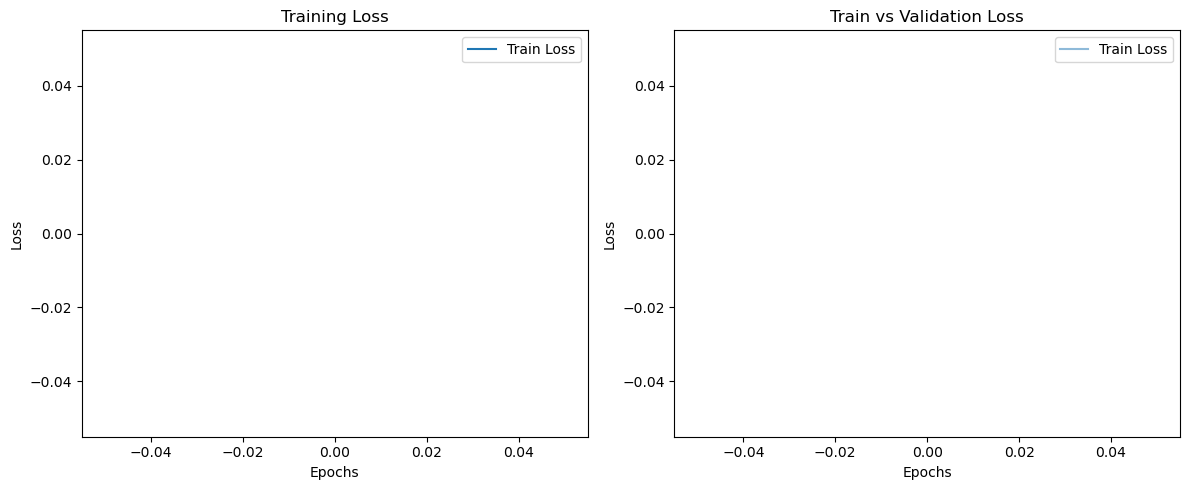

[INFO] Grafici training salvati in 'training_metrics.png'
--> Last Model Saved at garbage_custom_1_best.pth
[TRAIN] Completato.


In [31]:
train(cfg)

/Users/marcopilia/Desktop/Garbage_Classifier/Custom/Models/GarbageCustom_1.py:103: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path, map_location=d

[INFO] Device: MPS (Apple Silicon)
[INFO] Dati -> Train: 9730, Val: 2085, Test: 2086

[TEST] Avvio test modello salvato...


Testing: 100%|██████████| 2086/2086 [00:07<00:00, 277.37it/s]


[RESULT] Test Set Accuracy: 19.70%


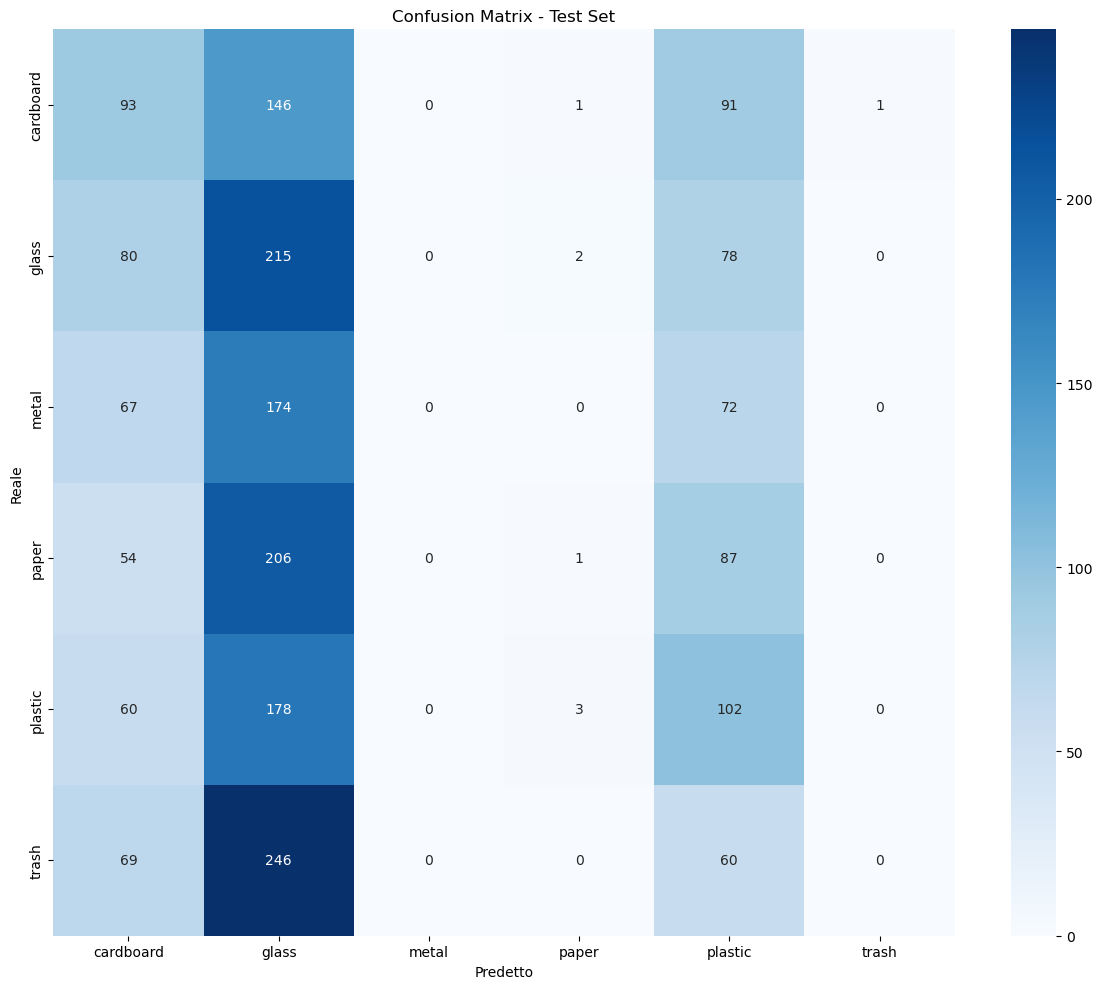

[INFO] Matrice di confusione salvata in 'confusion_matrix.png'


In [34]:
test(cfg)